# Mahjong Master Project Notebook

Cunhan Zou (A0248334A) <br>
Kiasheng Deng (A0242101E) <br>
Ziwei Peng (A0248341H)

# Background & Motivation

&emsp;Mahjong is a tile-based game that was developed in the 19th century in China and has spread
throughout the world since the early 20th century. The game and its regional variants are widely played
throughout East and Southeast Asia. Some of the interests in playing Mahjong are served for gambling,
socializing, and entertaining, while the main attractiveness behind is to figure out rules out of chaos.

&emsp;As all of us are Mahjong players, we would like to make the mahjong game a little bit easier by
applying some AI techniques to make decisions for us. In decision-making, the understanding of the
current situation is crucial, which motivates us with the idea to try to identify all Mahjong tiles on deck. It
allows a full appreciation of what tiles we have and what tiles are in the pool and discarded.

&emsp;Our proposal is to implement a classification project to distinguish different Mahjong tiles on the
deck. The project involves several stages, from image information extraction to model parsing, labeling,
and output classification. We will parse the input images from the Japanese mahjong game application
雀魂麻将 (Maj Souls) as the source of the dataset.

&emsp;This project is aiming for Japanese mahjong games, which will be slightly different from Chinese mahjong. 
The tiles in Maj Souls can be divided into four different types, Wan, Tiao, Tong, and Character. 
The first three types each have nine different tile
representations, ranging from number one to nine. The last type of Character includes seven distinct
tiles, namely Dong, Xi, Nan, Bei, Zhong, Fa, and Bai. All tiles will add up to 34 different image
representations in total. Our project targets to mainly identify the above 34 different Mahjong images.

&emsp;We are proposing a model to first train and identify the images we collect from Maj Souls, forming a
dataset of 34 different labels. As the image might be oriented differently or slightly miss certain pixels
and data augmentation methods can be applied to our dataset, our training will include all possible
image conditions. Accuracy of tiles is key to decision-making models, we will aim to achieve around
100% accuracy on validation and test datasets. The logic behind Mahjong is somewhat straightforward,
our model would expand further to implement automated decision-making for players, nevertheless
limited by the timing and resources of our project.

&emsp;Firstly, we imported some modules and defined serveral variables for later use.

The link to our raw dataset:
    https://drive.google.com/file/d/1Bkf6VaAbB_wyCmmuUAvRNQhm1FkRsjN3/view?usp=share_link

In [4]:
import os
dataset_zip = 'dataset_raw.zip'
if not os.path.exists(dataset_zip):
    !wget --no-check-certificate "https://drive.google.com/uc?export=download&id=1Bkf6VaAbB_wyCmmuUAvRNQhm1FkRsjN3" -O dataset_raw.zip

In [5]:
# import required modules
import random
import skimage.io as io
from skimage.transform import resize, rotate
from skimage.util import random_noise, img_as_ubyte
from skimage.draw import rectangle
import zipfile
import shutil
import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# assign directory
directory_dataset = './dataset/'
directory_train = './dataset/train'
directory_test = './dataset/test'
output_directory_dataset = './dataset_preprocessed'
output_directory_train = './dataset_preprocessed/train'
output_directory_test = './dataset_preprocessed/test'
# This may cause some error in some operation systems.
skip_list = ['.DS_Store']
k = 2

shutil.rmtree(directory_dataset, ignore_errors=True)
shutil.rmtree(output_directory_dataset, ignore_errors=True)

with zipfile.ZipFile("./dataset_raw.zip", 'r') as zip_ref:
        zip_ref.extractall(".")

def load_data():
    image_size = (64, 64)
    batch_size = 32

    path = "."

    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset_train = torchvision.datasets.ImageFolder(root = path + "/dataset_preprocessed/train", transform=transform)
    dataset_test = torchvision.datasets.ImageFolder(root = path + "/dataset_preprocessed/test", transform=transform)
    return dataset_train, dataset_test

def data_loader(dataset_train, dataset_test):
    batch_size = 32
    train_data_loader = DataLoader(dataset_train, batch_size, shuffle=True, num_workers=0)
    test_data_loader = DataLoader(dataset_test, batch_size, shuffle=True, num_workers=0)
    return train_data_loader, test_data_loader

# Data Collection

&emsp;The dataset are jointly collected by all three members(and yes, by our hands!). We collected a lot of pictures of mahjong tiles from the data source and labeled them.

&emsp;The datasets come with different orientations, scales, and potentially with occlusion. It helps when we need to identity the mahjong tiles from different players (because they will drop their tiles to their directions). Of course mahjong tiles may be dropped in an irregular direction in real mahjong games, it's simpler that in this game we only have 5 orientations as marked in the following image.

&emsp;The dataset includes all 5 types of mahjong tiles images.

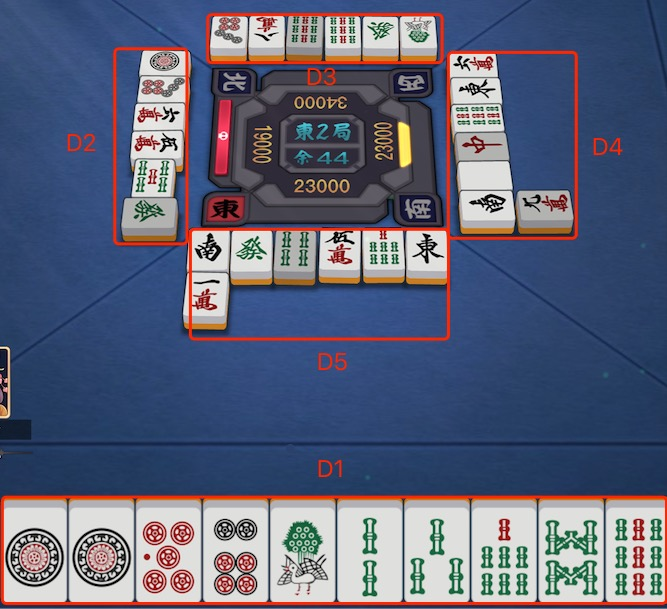

&emsp;The data will come with possible occlusions since we know somtimes the image may be partly covered by other windows, but we still expect our model to be able to predict the tiles correctly. So we'll add random noise and occlusions in the data augmentation part to enhance our dataset.

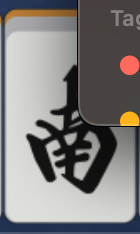

# Data Exploration (Raw)

&emsp;Let's start with data exploration on raw dataset. The following code cell imports the raw dataset.

In [6]:
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset_raw = torchvision.datasets.ImageFolder(root = directory_train, transform=transform)

&emsp;Let's start with the first 4 examples and use `matplotlib.pyplot` to see some sample images.

&emsp;The first 4 examples all belong to label 0.

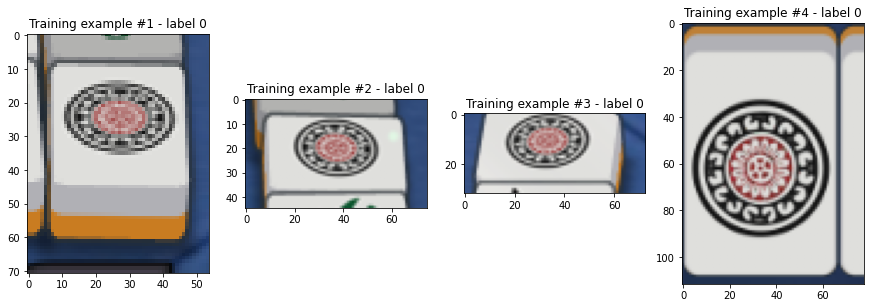

In [7]:
num_images = 4
fig, axes = plt.subplots(1, num_images, figsize=(15, 10))
for i in range(num_images):
    axes[i].imshow(dataset_raw[i][0].permute(1, 2, 0))
    axes[i].set_title(f"Training example #{i + 1} - label {dataset_raw[i][1]}")

# Data Preprocessing & Data Augmentation

&emsp;Firstly, we have to split the dataset first, for it'll cause possible data leak if we do shuffle and split after data augmentation if the new images are mixed.

In [8]:
# random sample and split train/test dataset.
enable_split = True

random.seed(0)

# split before data enhancement to avoid data leak
if enable_split:
    for filename in os.listdir(directory_train):
        f = os.path.join(directory_train, filename)
        f_out = os.path.join(directory_test, filename)
        if not os.path.exists(f_out):
            os.makedirs(f_out)
        if os.path.isdir(f):
            samples = random.sample(os.listdir(f), k)
            for p in samples:
                from_name = os.path.join(f, p)
                to_name = os.path.join(f_out, p)
                shutil.move(from_name, to_name)

&emsp;Then we are able to do some data preprocessing. We resize the pictures to square with fixed size(64*64) and the parameter is specified by user. We need to convert them to the same size so we could be able to use them as the input of our data models.

&emsp;Although we don't have a large number of data samples like hundreds of thousands but we will do some data augmentation to enhance our dataset, which includes adding randoms noises, rotations and occlusions to improve our model's generalization.

In [9]:
# Debug switch
is_debug = False
# we only do preprocessing and augmentation for 1 time because it takes lot of time.
# If want to reproduce, set `enable_preprocessing = True`.
# If you only want to see what it generates, set `enable_preprocessing = True` and `is_debug = True`
# Then samples are generated into "./dataset_preprocessed"
enable_preprocessing = not os.path.exists("./dataset_preprocessed.zip")
# output image size
fix_size = 64

# save image with noise augmentation
def noise_save(name, content):
    io.imsave(name + '-1.png', img_as_ubyte(content))
    image_noised_gaussian = random_noise(content, mode='gaussian', mean=0, var=0.01, clip=True)
    io.imsave(name + '-2.png', img_as_ubyte(image_noised_gaussian))
    image_noised_gaussian_2 = random_noise(content, mode='gaussian', mean=0, var=0.02, clip=True)
    io.imsave(name + '-3.png', img_as_ubyte(image_noised_gaussian_2))
    image_noised_s_p = random_noise(content, mode='s&p', salt_vs_pepper=0.5, clip=True)
    io.imsave(name + '-4.png', img_as_ubyte(image_noised_s_p))
    image_noised_s_p_2 = random_noise(content, mode='s&p', salt_vs_pepper=0.2, clip=True)
    io.imsave(name + '-5.png', img_as_ubyte(image_noised_s_p_2))

# save image with random occlusion
def occlusion_save(name, content):
    image_occlusion = content.copy()
    size_x = random.randrange(fix_size // 3, fix_size // 2)
    size_y = random.randrange(fix_size // 3, fix_size // 2)
    rr, cc = rectangle((random.randrange(0, fix_size - size_x),
                        random.randrange(0, fix_size - size_y)), 
                       extent=(size_x, size_y))
    image_occlusion[rr, cc] = 1
    io.imsave(name + '-1.png', img_as_ubyte(image_occlusion))

# save image with rotation augmentation
def rotate_save(name, content):
    for i in range(6, 7):
        occlusion_save(name + '-' + str(i), content)
    noise_save(name + '-1', content)
    content = rotate(content, 90)
    for i in range(7, 8):
        occlusion_save(name + '-' + str(i), content)
    noise_save(name + '-2', content)
    content = rotate(content, 90)
    for i in range(8, 9):
        occlusion_save(name + '-' + str(i), content)
    noise_save(name + '-3', content)
    content = rotate(content, 90)
    for i in range(9, 10):
        occlusion_save(name + '-' + str(i), content)
    noise_save(name + '-4', content)

map_dirs = [
    [directory_train, output_directory_train],
    [directory_test, output_directory_test],
]

if enable_preprocessing:
    # iterate over files in that directory
    for dir in map_dirs:
        for filename in os.listdir(dir[0]):
            f = os.path.join(dir[0], filename)
            f_out = os.path.join(dir[1], filename)
            if not os.path.exists(f_out):
                os.makedirs(f_out)
            if os.path.isdir(f):
                for imgname in os.listdir(f):
                    if (imgname in skip_list):
                        continue
                    img = os.path.join(f, imgname)
                    img_raw = io.imread(img)
                    # Resize all data to fix size
                    image_resized = resize(img_raw, (fix_size, fix_size), anti_aliasing=True)
                    rotate_save(os.path.join(f_out, imgname[0: imgname.find('.')]), image_resized)
                    if is_debug:
                        io.imshow(image_resized)
                        break
            if is_debug:
                break
else:
    shutil.rmtree("./dataset_preprocessed", ignore_errors=True)
    with zipfile.ZipFile("./dataset_preprocessed.zip", 'r') as zip_ref:
            zip_ref.extractall(".")

In [10]:
!find ./dataset_preprocessed -name ".DS_Store" -delete
shutil.make_archive("./dataset_preprocessed", "zip", '.', './dataset_preprocessed')

'/Users/kaishengdeng/Desktop/Coding/Mahjong-Master/dataset_preprocessed.zip'

&emsp;Now the new data after preprocessing has been saved to preprocessed folder. Compress the file so we can use it for later training conveniently.

# Data Exploration (Processed)

&emsp;Load our data as standard input:

In [11]:
dataset_train, dataset_test = load_data()

&emsp;One of the first steps when working with a new data set is exploring. The data are jointly collected, labelled and reviewed by all three of the team members to ensure its correctness and practicality.

&emsp;Our data have been preprocessed and zipped into the file 'dataset_preprocessed.zip'. In the previous data block we have unzipped the data into a temporary directory and we'll do our future research over this.

&emsp;With that in mind, let's see some descriptions to see some overview of our dataset and take a look at how the samples are represented.

The size of the full dataset is: 15048

The total class of the full dataset: ['1b', '1t', '1w', '2b', '2t', '2w', '3b', '3t', '3w', '4b', '4t', '4w', '5b', '5t', '5w', '6b', '6t', '6w', '7b', '7t', '7w', '8b', '8t', '8w', '9b', '9t', '9w', 'bai', 'bei', 'dong', 'fa', 'nan', 'xi', 'zhong']

Distribution of dataset_train:[432, 456, 456, 456, 480, 456, 480, 480, 456, 360, 456, 432, 432, 456, 432, 456, 456, 432, 432, 456, 432, 456, 456, 432, 384, 456, 456, 432, 432, 432, 432, 432, 432, 432]


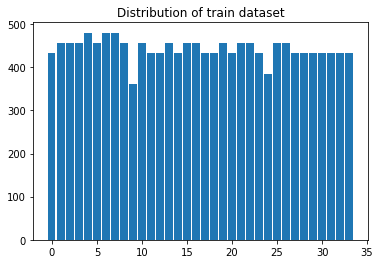

Distribution of dataset_test:[48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48]


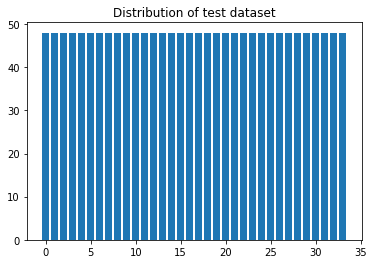

The index of these train classes: {'1b': 0, '1t': 1, '1w': 2, '2b': 3, '2t': 4, '2w': 5, '3b': 6, '3t': 7, '3w': 8, '4b': 9, '4t': 10, '4w': 11, '5b': 12, '5t': 13, '5w': 14, '6b': 15, '6t': 16, '6w': 17, '7b': 18, '7t': 19, '7w': 20, '8b': 21, '8t': 22, '8w': 23, '9b': 24, '9t': 25, '9w': 26, 'bai': 27, 'bei': 28, 'dong': 29, 'fa': 30, 'nan': 31, 'xi': 32, 'zhong': 33}

The index of these test classes: {'1b': 0, '1t': 1, '1w': 2, '2b': 3, '2t': 4, '2w': 5, '3b': 6, '3t': 7, '3w': 8, '4b': 9, '4t': 10, '4w': 11, '5b': 12, '5t': 13, '5w': 14, '6b': 15, '6t': 16, '6w': 17, '7b': 18, '7t': 19, '7w': 20, '8b': 21, '8t': 22, '8w': 23, '9b': 24, '9t': 25, '9w': 26, 'bai': 27, 'bei': 28, 'dong': 29, 'fa': 30, 'nan': 31, 'xi': 32, 'zhong': 33}



In [12]:
print(f"The size of the full dataset is: {len(dataset_train)}\n")

print(f"The total class of the full dataset: {dataset_train.classes}\n")  # classes names

label_cnt = []
for i in range(len(dataset_train.classes)):
    label_cnt.append(0)
for i in range(len(dataset_train)):
    label_cnt[dataset_train[i][1]] += 1
print(f"Distribution of dataset_train:{label_cnt}")
plt.bar(range(len(dataset_train.classes)), label_cnt)
plt.title(f"Distribution of train dataset")
plt.show()

label_cnt = []
for i in range(len(dataset_test.classes)):
    label_cnt.append(0)
for i in range(len(dataset_test)):
    label_cnt[dataset_test[i][1]] += 1
print(f"Distribution of dataset_test:{label_cnt}")
plt.bar(range(len(dataset_test.classes)), label_cnt)
plt.title(f"Distribution of test dataset")
plt.show()

print(f"The index of these train classes: {dataset_train.class_to_idx}\n") # index of classes
print(f"The index of these test classes: {dataset_test.class_to_idx}\n") # index of classes

assert(dataset_train.class_to_idx == dataset_test.class_to_idx)

&emsp;An imbalanced dataset is defined by great differences in the distribution of the classes in the dataset. This means that a dataset is biased towards a class in the dataset. If the dataset is biased towards one class, an algorithm trained on the same data will be biased towards the same class. The model learns more from biased examples as opposed to the examples in the minority class. One might end up with a scenario where a model assumes that any data you feed it belongs to the majority class. This, as a result, makes a model seem naïve in its predictions, regardless of achieving high accuracy scores. From the two plots above, we can see that the dataset is well balanced and we can safely use it to train our model.

&emsp;Here I choose `index=0` to look at the very first sample. We first notice `dataset[0][1]=0`, meaning this entry is the type `0` - '1b'. We will confirm this shortly by visualizing some of these samples. We then notice each entry is an integer ranging from `0-1.0`. This representation is uncommon when working with images since they should be within the range of `0-255`. The numerical entries are interpreted as pixel intensities typically shown in gray-scale ranging between `0` (black) and `255` (white). But we use `torchvision.transforms.ToTensor` in our loading process and it will `converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]` according to the document.

In [13]:
index = 0
print(f"feature: {dataset_train[index][0].shape} - label {dataset_train[index][1]}")
print(dataset_train[index][0])
print(f"testset[{index}] range from {torch.min(dataset_train[index][0])} to {torch.max(dataset_train[index][0])}.")

feature: torch.Size([3, 64, 64]) - label 0
tensor([[[0.8745, 0.8745, 0.8471,  ..., 0.2000, 0.2000, 0.2000],
         [0.8745, 0.8745, 0.8627,  ..., 0.2039, 0.2039, 0.2039],
         [0.8745, 0.8745, 0.8706,  ..., 0.2078, 0.2078, 0.2118],
         ...,
         [0.0941, 0.0824, 0.0706,  ..., 0.2039, 0.1961, 0.1922],
         [0.0824, 0.1059, 0.1333,  ..., 0.2000, 0.1961, 0.1882],
         [0.1843, 0.2000, 0.2118,  ..., 0.1961, 0.1922, 0.1843]],

        [[0.8745, 0.8745, 0.8471,  ..., 0.3059, 0.3059, 0.3059],
         [0.8745, 0.8745, 0.8627,  ..., 0.3098, 0.3098, 0.3098],
         [0.8745, 0.8745, 0.8706,  ..., 0.3098, 0.3137, 0.3176],
         ...,
         [0.1529, 0.1255, 0.1059,  ..., 0.3216, 0.3176, 0.3098],
         [0.0863, 0.1059, 0.1294,  ..., 0.3216, 0.3137, 0.3059],
         [0.1765, 0.1882, 0.2039,  ..., 0.3137, 0.3059, 0.2980]],

        [[0.8627, 0.8627, 0.8392,  ..., 0.4980, 0.4980, 0.4980],
         [0.8627, 0.8627, 0.8510,  ..., 0.5020, 0.5020, 0.5020],
         [0.862

&emsp;Let's use `matplotlib.pyplot` to see some sample images.

&emsp;Let's start with the first 4 examples.

&emsp;The first 4 examples all belong to label 0 and some images are generated from data augmentation to obtain better generalization of our model. We can see some examples with random noise in them.

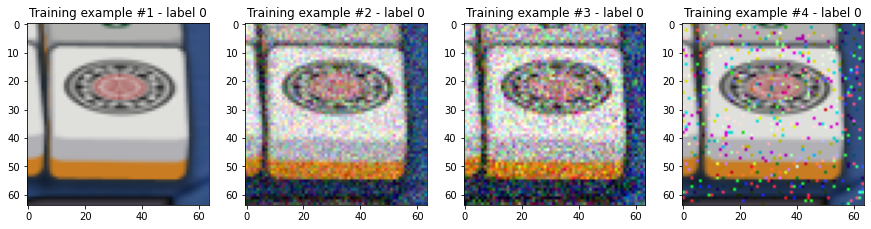

In [14]:
num_images = 4
fig, axes = plt.subplots(1, num_images, figsize=(15, 10))
for i in range(num_images):
    axes[i].imshow(dataset_train[i][0].permute(1, 2, 0))
    axes[i].set_title(f"Training example #{i + 1} - label {dataset_train[i][1]}")

&emsp;Let's continue with the some examples from type '1b'.

&emsp;We can see from the following examples that some images are processed with rotation and random occlusions. That's one reason why we need deep learning model here.

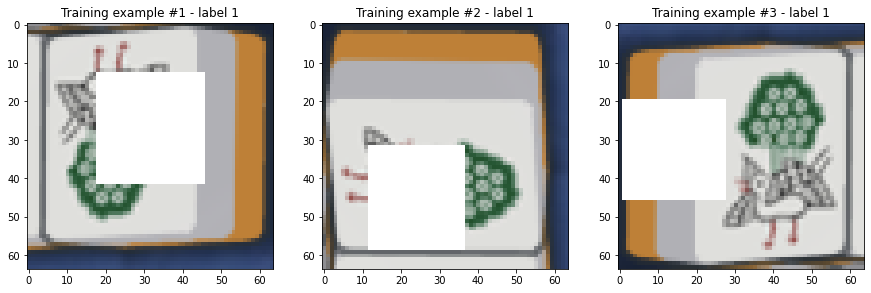

In [15]:
images = [573, 574, 575]
fig, axes = plt.subplots(1, len(images), figsize=(15, 10))

for i in range(len(images)):
    index = images[i]
    axes[i].imshow(dataset_train[index][0].permute(1, 2, 0))
    axes[i].set_title(f"Training example #{i + 1} - label {dataset_train[index][1]}")

&emsp;Let's continue to explore some random images.

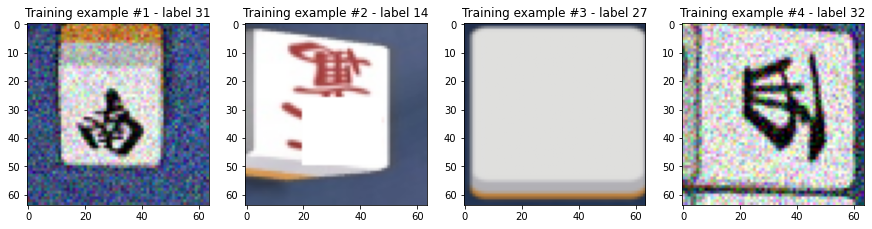

In [16]:
from random import randint
num_images = 4
random.seed(0)
fig, axes = plt.subplots(1, num_images, figsize=(15, 10))
for i in range(num_images):
    value = randint(0, len(dataset_train))
    axes[i].imshow(dataset_train[value][0].permute(1, 2, 0))
    axes[i].set_title(f"Training example #{i + 1} - label {dataset_train[value][1]}")

# Data Loading

&emsp;We already split our data to training set and validation set. Simply load them from our preprocessed data.

In [17]:
# validation_set_ratio = 0.2
# n = len(dataset)  # total number of examples
# n_test = int(validation_set_ratio * n)
# subsets = torch.utils.data.random_split(dataset, [n - n_test, n_test], generator=torch.Generator().manual_seed(42))
# train_set = subsets[0]
# test_set = subsets[1]
# print(train_set.__len__(), test_set.__len__()) # [train_set, validation_set]
# print(type(train_set.dataset))

dataset_train, dataset_test = load_data()
train_data_loader, test_data_loader = data_loader(dataset_train, dataset_test)

In [18]:
# Sample for using the above data loaders
for i, data in enumerate(train_data_loader, 0):
    # iteration index, torch.Size([32, 64, 64, 3]) torch.Size([32])
    print(i, data[0].permute(0, 2, 3, 1).shape, data[1].shape)
    break

0 torch.Size([32, 64, 64, 3]) torch.Size([32])


# Prepare for Model Training

In [19]:
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
!pip install -q --upgrade torch_snippets
from torch_snippets.torch_loader import Report
from torch.optim.lr_scheduler import ExponentialLR

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

loss_function = nn.CrossEntropyLoss()
def criterion(predictions, targets):
    loss = loss_function(predictions, targets)
    acc = (torch.max(predictions, dim=1)[1] == targets).float().mean()
    return loss, acc

num_epoch = 1
lr_decay_gamma = 0.9

def train_batch(model, data, optimizer, criterion):
    model.train()
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss, acc = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss, acc

@torch.no_grad()
def test_batch(model, data, criterion):
    model.eval()
    inputs, labels = data[0].to(device), data[1].to(device)
    outputs = model(inputs)
    loss, acc = criterion(outputs, labels)
    return loss, acc

# MLP Baseline Model

&emsp;Building the MLP Baseline model. Here is the simple model structure.
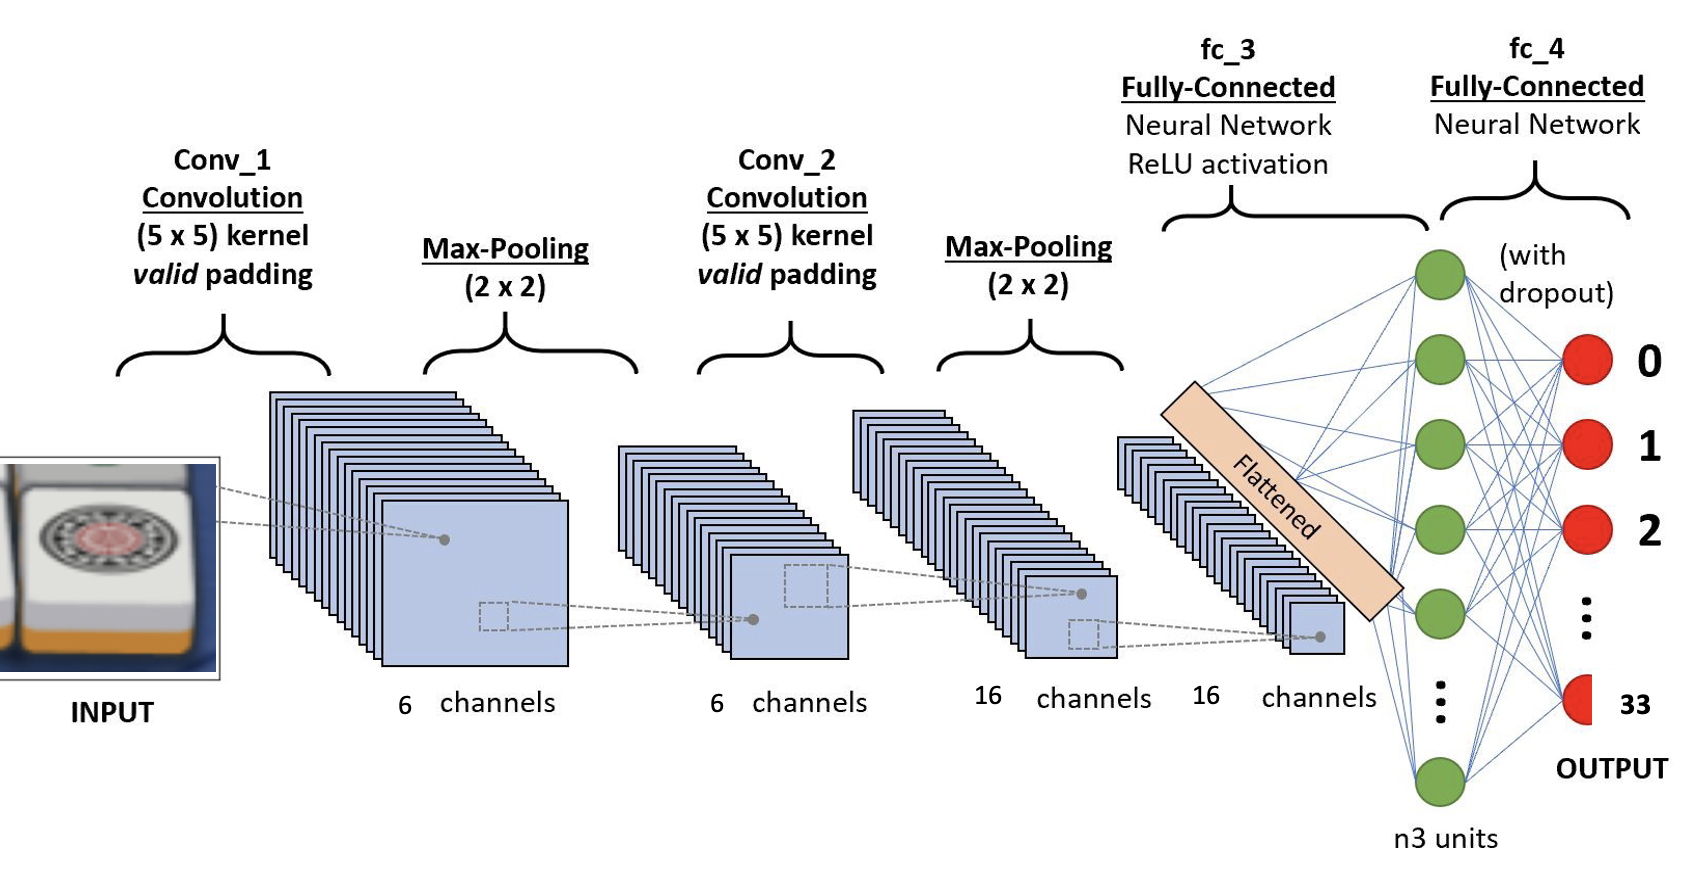

In [20]:
import torch.nn.functional as F

class MLP(nn.Module):
    # Define Multilayer Perceptron
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2704, 768)
        self.fc2 = nn.Linear(768, 84)
        self.fc3 = nn.Linear(84, 34)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 
    
model = MLP()
log_mlp = Report(num_epoch)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=lr_decay_gamma, verbose=True)

for epoch in range(num_epoch):
    N = len(train_data_loader)
    for i, data in enumerate(train_data_loader, 0):
        loss, acc = train_batch(model, data, optimizer, criterion)
        if i % 5 == 0:
            log_mlp.record(pos=epoch + (i + 1) / N, train_loss=loss, train_acc=acc, end='\r')
    print()

    N = len(test_data_loader)
    for i, data in enumerate(test_data_loader, 0):
        loss, acc = test_batch(model, data, criterion)
        if i % 5 == 0:
            log_mlp.record(pos=epoch + (i + 1) / N, test_loss=loss, test_acc=acc, end='\r')
    print()
    scheduler.step()

print("train_acc:", [v for pos, v in log_mlp.train_acc][-1], "|test_acc:", [v for pos, v in log_mlp.test_acc][-1])


Adjusting learning rate of group 0 to 1.0000e-03.
EPOCH: 1.000  train_loss: 1.954  train_acc: 0.375  (27.46s - 0.00s remaining))
EPOCH: 1.000  test_loss: 1.505  test_acc: 0.562  (29.17s - 0.00s remaining))))
Adjusting learning rate of group 0 to 9.0000e-04.
train_acc: 0.375 |test_acc: 0.5625


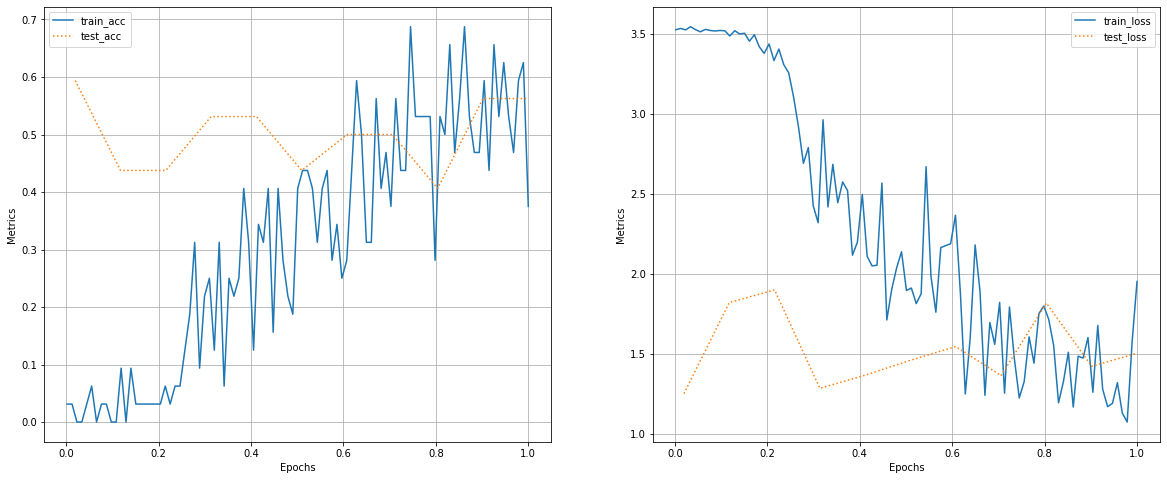

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

log_mlp.plot(['train_acc', 'test_acc'], ax=ax1)
plt.savefig('mlp_acc.png')

log_mlp.plot(['train_loss', 'test_loss'], ax=ax2)
plt.savefig('mlp_loss.png')

# Resnet Model

&emsp;Building a ResNet34 model, here is the architechture of ResNet34

![Arch of ResNet34](https://editor.analyticsvidhya.com/uploads/38371XTo6Q.png)

In [23]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, down_sample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), stride=(stride, stride), padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), stride=(1,1), padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.down_sample = down_sample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.down_sample:
            residual = self.down_sample(x)
        out += residual
        out = self.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7,7), stride=(2,2), padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.max_pool = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=1)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=1)
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(2048, num_classes)

    def _make_layer(self, block, planes, blocks, stride = 1):
        down_sample = None
        if stride != 1 or self.in_planes != planes:
            down_sample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes, kernel_size=(1,1), stride=(stride,stride)),
                nn.BatchNorm2d(planes)
            )
        layers = []
        layers.append(block(self.in_planes, planes, stride, down_sample))
        self.in_planes = planes
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.max_pool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = ResNet(ResidualBlock, [3,4,6,3], num_classes=34).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=lr_decay_gamma, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


&emsp;Now train the model.

In [24]:
import gc
import datetime

now = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
weight_save_path = 'weight-resnet34-' + now
log_resnet = Report(num_epoch)
for epoch in range(num_epoch):
    N = len(train_data_loader)
    for i, data in enumerate(train_data_loader, 0):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log_resnet.record(pos=epoch + (i + 1) / N, train_loss=loss, train_acc=acc, end='\r')
    print()
    torch.save(model.state_dict(), weight_save_path)

    N = len(test_data_loader)
    for i, data in enumerate(test_data_loader, 0):
        loss, acc = test_batch(model, data, criterion)
        log_resnet.record(pos=epoch + (i + 1) / N, test_loss=loss, test_acc=acc, end='\r')
    print()
    scheduler.step()
    gc.collect()
    
print("train_acc:", [v for pos, v in log_resnet.train_acc][-1], "|test_acc:", [v for pos, v in log_resnet.test_acc][-1])

EPOCH: 0.013  train_loss: 3.838  train_acc: 0.062  (18.34s - 1421.64s remaining)

KeyboardInterrupt: 

&emsp;Now visualize the result

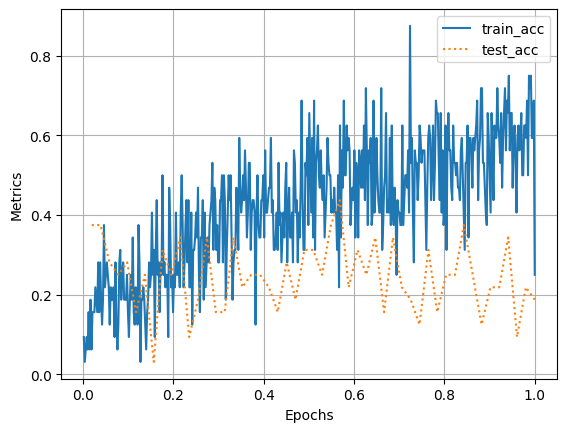

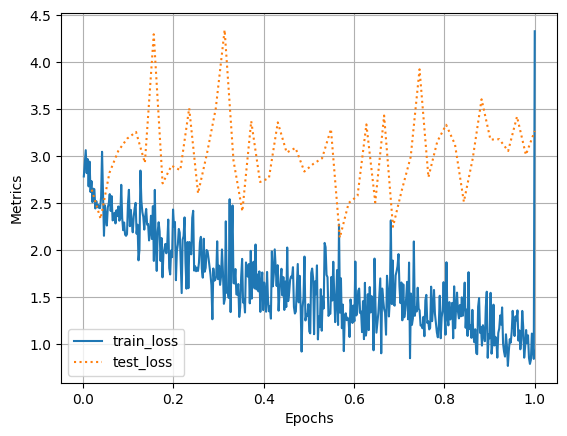

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

log_resnet.plot(['train_acc', 'test_acc'], ax=ax1)
plt.savefig('resnet_acc.png')

log_resnet.plot(['train_loss', 'test_loss'], ax=ax2)
plt.savefig('resnet_loss.png')

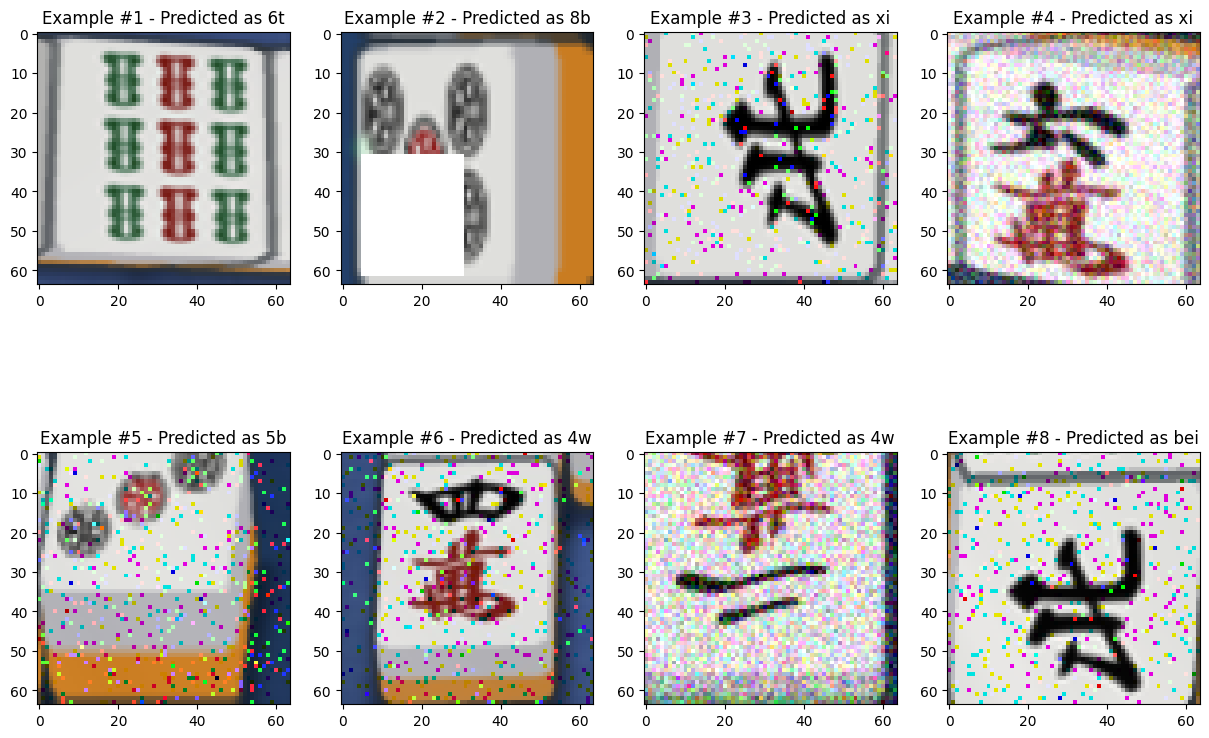

In [54]:
def sample_prediction_data_loader(dataset_test):
    bs = 1
    sample_pred_data_loader = DataLoader(dataset_test, batch_size=bs, shuffle=True, num_workers=0)
    return sample_pred_data_loader

sample_loader = sample_prediction_data_loader(dataset_test)
num_images = 8
cnt_images = 0
fig, axes = plt.subplots(2, 4, figsize=(15, 10))
label_to_class = {v: k for k, v in dataset_test.class_to_idx.items()}
for i, data in enumerate(sample_loader, 0):
    row = i // 4
    col = i % 4
    axes[row][col].imshow(data[0][0].permute(1, 2, 0))
    inputs, labels = data[0].to(device), data[1].to(device)
    outputs = model(inputs)
    axes[row][col].set_title(f"Example #{i + 1} - Predicted as {label_to_class[int(outputs.argmax())]}")
    cnt_images += 1
    if cnt_images == num_images:
        break

# Garbage Collection

&emsp;Let's do some clean up before finish.

In [ ]:
os.remove(dataset_zip)
os.remove("./dataset_preprocessed.zip")
shutil.rmtree(directory_dataset, ignore_errors=True)
shutil.rmtree(output_directory_dataset, ignore_errors=True)

# Model Analysis & Conclusion

# Looking into Future

&emsp;The Mahjong project is an image classification task of categorizing and assigning labels to groups of pixels or vectors within an image dependent on particular rules. When we explore different models of image classification, we are swimming in the field of computer vision.<br>

&emsp;From supervised learning, unsupervised learning, to the integration of general machine learning techniques, image classification has leveraged the potential of traditional algorithms and AI to learn hidden knowledge from a dataset of organized and unorganized samples. Within all those machine learning and deep learning models, neural networks have been the success.<br>

&emsp;In 2012, a type of large deep convolutional neural network callsed AlexNet appeared on the stage with extraordinary performance on ILSVRC. It marked the start of a broad and deep development of CNN, such as VGGNet, GoogleNet, DenseNet, and ResNet (which we applied in our project).<br>

&emsp;The bottom line for CNNs reply on CNNs characteristic of self-training models. That said, their effectiveness only increases as they are fed more data in the form of annotated images. Today, CNN mark the current state of AI. In 2021, it has shown exciting results for the application of Vision Transformers (ViT) in computer vision tasks. In July 2022, the release of YOLOv7 marked a new era in modeling which surpasses all previously known models in terms of speed and accuracy. We believe more advanced neural network technologies are coming and we are excited to see more to further increase the model and change our lives.<br>

&emsp;And for our task, it's important to not only classify the tiles from the images, but also detect objects(classification and localization of the tiles on a mahjong table), because we need such information to know exactly which tiles are discarded and who discard those tiles to do further decision making. We already learned some technologies on class recently like R-CNN and we may need more future study to investigate on how we can make use of it.


# Appendix